![](images/ucl_logo.png)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modelling-Land-Use-change-with-socio-economic-drivers:-Teacher-page" data-toc-modified-id="Modelling-Land-Use-change-with-socio-economic-drivers:-Teacher-page-1">Modelling Land Use change with socio-economic drivers: Teacher page</a></span></li><li><span><a href="#Gathering-socio-economic-data" data-toc-modified-id="Gathering-socio-economic-data-2">Gathering socio-economic data</a></span></li><li><span><a href="#Applying-the-models" data-toc-modified-id="Applying-the-models-3">Applying the models</a></span><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-3.1">Summary</a></span></li></ul></li></ul></div>

![](images/class_movie4.gif)

## Modelling Land Use change with socio-economic drivers: Teacher page

Having derived a dataset of urban land use, we can calculate urban land use change per year.

Following the general approach of [Seto & Kaufmann (2003)](reading/SetoandKaufmann2003.pdf), we will build a multi-linear model to attempt to describe the urban land use change per year (the 'y' variable) as a function of a number of key socioeconomic factors (e.g. capital investment, land productivity, population, wage rates, etc) (the '$x$' variables). 

We suppose that we have observation ('$y$') data for $N_{years}$ and $N_{params}$ of socioeconomic factors for each of these years.

So, we will derive a (multi)*linear* model that we could phrase as:

**Equation 1:**
$$
y = c +  M x                
$$

where we supply the following information:

* $y$ is a column vector of length $N_{years} - 1$ with urban land use change per year. The minus 1 is because we must calculate land use *change* from one year to the next.
* $x$ is an information matrix of size $N_{params} - 1$ by  $N_{years} - 1$ (one entry for each year, for each socioeconomic factor). The minus 1 associated with $N_{params}$ is because we have an additional parameter, $c$.

The model parameters above (i.e. the information we need to derive by fitting to the data) are called $M$ and $c$. Here, $M$ would be a row vector of size $N_{params} - 1$ and $c$ is a scalar. So there are a total of $N_{params}$ *unknown* values (the model parameters) that we need to estimate. 

Following the example in the paper, we will use the following in $x$:

* $x_1$: Investment in capital construction / population
* $x_2$: value of gross agricultural output / agriculture population
* $x_3$: log(wages in non-state, non-collective units)
* $x_4$: log(average total wage)
* $x_5$: (value of gross agricultural output/Agricultural land) / (value of gross industrial output / Urban land)

This will give a model with 6 parameters that we need to estimate (i.e. 6 unknowns) that we could call $p_0, p_1, p_2, p_3, p_4, p_5$. We could then write the general model more specifically as:

**Equation 2:**

$$
y = p_0 + p_1 x_1 + p_2 x_2 + + p_3 x_3 + p_4 x_4 + p_5 x_5
$$

Note that the final term ($x_5$) requires that we have data for Agricultural and Urban land, which we will need to derive from the remote sensing data for each year of observation.

The rest of the data will come from official statistics. An example for the years 1987 to 2000 is given below to give you a feel for the sort of information you will be using:

## Gathering socio-economic data

There are many freely available online database for downloading important socio-economic data. Some examples are the Center for International Earth Science Information Network (CIESIN) at Columbia University and the World Bank. The data we will be using here are from the [Guangdong Statistical Yearbook](http://www.gdstats.gov.cn/tjnj/2006/ml_e.htm).

![](images/page.png)

A spreadsheet with relevant data has been compiled and can be downloaded [here](files/Guangdong-Yearbook-2019.xlsx)

Note that the classification results in the spreadsheet are the lecturers' results and **must not** be used in student analyses (i.e. you must put in your own classification results).

You will only be able to run the model for years that you have driving (socioeconomic) and Landsat data.


##  Applying the models

Here, we provide some code to calibrate and test the required model:

In [37]:
# read LUC data  & socio data
book = 'files/Guangdong-Yearbook-2019.xlsx'
%matplotlib inline

In [58]:
import xlrd
import numpy as np
import pandas as pd

# This part reads the data from the excel file
# given above as 'book'

# utility
def getfloats(sheet,c):
    return np.array([i for i in sheet.col_values(c)[1:] \
                     if type(i) == float])
# open the excel file
bookf = xlrd.open_workbook(book)
sheet = bookf.sheet_by_index(0) # Get the first sheet
# get the column headings
headings = sheet.row_values(0,end_colx=13)
# read the years from 1st col
year = getfloats(sheet,0)
# read each heading
data = {}
n = len(year)
for i,h in enumerate(headings):
    data[h] = getfloats(sheet,i)[:n]
print(year)

[1987. 1988. 1989. 1990. 1991. 1992. 1993. 1994. 1995. 1996. 1997. 1998.
 1999. 2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007. 2008. 2009. 2010.
 2011. 2012. 2013. 2014. 2015. 2016. 2017. 2018.]


In [64]:
# lets see what we have
print (year.shape)
n = year.shape[0]
for i in headings[1:9]:
    print(i,data[i].shape)
    n = min([n,data[i].shape[0]])

(32,)
Complete investment in capital construction (固投) 亿元 (32,)
实际利用外资(万美元) (31,)
population (年末户籍总人口数) 万人 (31,)
wages in non-state, non-collective units 亿元 (31,)
value of gross agricultural output 亿元 (31,)
value of gross inductrial output 亿元 (31,)
agriculture population 万人 (31,)
average total wage 元 (31,)


In [81]:
# simplify and load variables
# shorten to length n-1 because need growth
# ie difference
investment = data[headings[1]][:n-1]
population = data[headings[3]][:n-1]
private_wage = data[headings[4]][:n-1]
agr_output = data[headings[5]][:n-1]
indust_output = data[headings[6]][:n-1]
agr_pop = data[headings[7]][:n-1]
avg_wage = data[headings[8]][:n-1]

#shortened year array
year = year[:n]

p1 = pd.DataFrame({'year':year[:n],
                  'investment':data[headings[1]][:n],
                  'population':data[headings[3]][:n],
                  'private_wage':data[headings[4]][:n],
                  'agr_output':data[headings[5]][:n],
                  'indust_output':data[headings[6]][:n],
                  'agr_pop':data[headings[7]][:n],
                  'avg_wage':data[headings[8]][:n]
                 })

# save the files as csv

p1.to_csv('files/Guangdong-Yearbook-2019.csv')
print(n)

31


In [99]:
%%R

UsageError: Cell magic `%%R` not found.


In [98]:
import rpy2.rinterface
## try this in R
%load_ext rpy2.ipython
%%R

ModuleNotFoundError: No module named 'rpy2'

1987.0 2017.0
31 (31,)


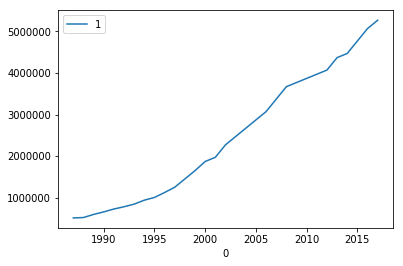

In [95]:
# You can plug your own values or urban land in here
# rather than modifying the spreadsheet
print(year[0],year[-1])
# type your own urban_land in here to override whats in
# the spreadsheet: this example has dummy values for > 2000
urban_land = [511000,520000,595000,
              656244,725000,780000,842833,938065,1003711,1122459,
              1250000,1450000,1650000,
              1870000,1970000,2270000,2470000,2670000,2870000,3070000,
              3370000,3670000,3770000,
              3870000,3970000,4070000,4370000,4470000,4770000,5070000,5270000]
urban_land = np.array(urban_land)[:n]
print(n,urban_land.shape)
p = pd.DataFrame(np.array([year,urban_land]).T)
p.plot(x=0)

In [84]:
%matplotlib inline

import statsmodels.api as sm
import matplotlib.pyplot as plt

# we dont trust ag land stats
# so instead here, we estimate it from the urban land
agr_land = 2*data['Urban pixels'].max() - data['Urban pixels']

growth = urban_land[1:]-urban_land[:-1]

urban_land = urban_land[:n-1]
agr_land   = agr_land[:n-1]

data_matrix = np.transpose(np.array([\
                investment[:n]*0+1,\
                investment[:n]/population[:n], \
                agr_output[:n]/agr_pop[:n], \
                np.log(private_wage[:n]), \
                np.log(avg_wage[:n]), \
                (agr_output[:n]/agr_land[:n])/(indust_output[:n]/urban_land[:n])\
                ]))[1:]
dyear = year[1:]
print (growth.shape)
print (urban_land.shape,data_matrix.shape,dyear.shape)

(29,)
(30,) (29, 6) (30,)


In [85]:
# regress growth as function of terms in
# data matrix
pp = np.linalg.lstsq(data_matrix, growth,rcond=None)
print ('parameters for multilinear-regression'),
for i,j in enumerate(pp[0]):
    print (f'p_{i}',j)

RMSE = np.sqrt(pp[1]/float(len(growth)))
print(RMSE)

print(year.shape,n,growth.shape)

parameters for multilinear-regression
p_0 1785199.9684917445
p_1 -287676.7893636485
p_2 677403.686073912
p_3 157734.0966670476
p_4 -306682.1761425342
p_5 3280971.6636894383
[52523.9147823]
(31,) 31 (29,)




year [1988. 1989. 1990. 1991. 1992. 1993. 1994. 1995. 1996. 1997. 1998. 1999.
 2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011.
 2012. 2013. 2014. 2015. 2016. 2017.]


data [  9000  75000  61244  68756  55000  62833  95232  65646 118748 127541
 200000 200000 220000 100000 300000 200000 200000 200000 200000 300000
 300000 100000 100000 100000 100000 300000 100000 300000 300000]


model [-11841.34255545  43324.78047154  83639.63251617  97374.20148421
  68139.05834852  45430.3470249   44108.7579053   97248.57513409
 124950.0112404  162205.1619841  217814.48897865 234656.52221849
 211045.30900568 173304.48502827 183401.09975089 192595.6113056
 198386.17502841 244220.83994015 196624.75890178 188016.32039863
 219896.08054522 144381.9964872   97677.38729516 201445.01439843
 180159.67271797 220778.58138297 154959.96902551 251655.12345886
 293401.38057835]


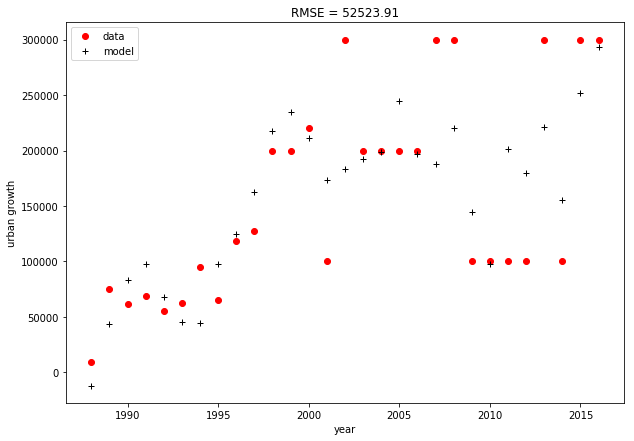

In [87]:
plt.figure(figsize=(10,7))
plt.title('RMSE = %.2f'%RMSE)
fwd = np.sum(pp[0]*data_matrix, axis=1)

plt.plot(year[1:-1], growth,'ro',label='data')
plt.plot(year[1:-1], fwd,'k+',label='model')
plt.xlabel('year')
plt.ylabel('urban growth')
plt.legend(loc='best')

print ('\n\nyear',dyear)
print ('\n\ndata',growth)
print ('\n\nmodel',fwd)

The material above provides all of the computer code you would need to apply the model, though you may wish to code it yourself in R. 

You **must** put in your own data from the classification result however (and this information must be traceable from your `Results`).

You should make some attempt to assess the accuracy of any model that you build. This is perhaps most readily achieved by some form of cross-validation (leave one sample out and test how well it is modelled).

You must explain and reference the models that you use (in a `Theory` section of simply a `Models` section) and claerly and traceably present all results (in `Model Results` section/sub-section). You must explain the approach taken for your accuracy assessment and present the results.

A discussion of the results (from the classification and modelling) must be in a `Discussion` section of the report. You should make sure to discuss the uncertainty in the classification(s) and the modelling. Comment on what the expected 'reliability' of such a model might be in this context.

A sufficient (i.e. pass) mark for the relevant section will be awarded if you correctly (assuming the classification results you have obtained are 'true') complete the model calibration (using the code above or excel or any other tool you are familiar with, provided you show your working), show all relevant results and properly plot the modelling results (as above). You will need to include more than a token effort at uncertainty estimation.

### Summary

* Using the data derived above, calibrate a model that describes urban land use change as a function of a set of socioeconomic factors, following the approach of Seto et al. (2002, 2003) **(of primary importance)**

![](images/comp.png)

* Test the model to assess uncertainty **(of secondary importance)**



[[Next](WriteUp.ipynb#5.0-Project-Write-up)] [[Home](CW-1-Pearl-River-Intro.ipynb#Geog-2021-Coursework)] [[Top](#4.0-Urban-Model)] [[Prev](DownloadEE.ipynb)]